<a href="https://colab.research.google.com/github/leticiatituana/ds-certification/blob/main/Copia_de_Laboratorio_02_Support_Vector_Machines_y_Modelos_basados_en_%C3%A1rboles_Titua%C3%B1a_%26_Due%C3%B1as.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 02 - Support Vector Machines y Modelos basados en árboles
Coding Bootcamps ESPOL, Machine Learning and Predictions, Cohorte II

Instructores: Galo Castillo López


Estudiantes: Wagner Dueñas, Leticia Tituaña

En este laboratorio implementaremos modelos SVM y modelos basados en árboles, utilizando `scikit-learn`, para predecir si un estudiante reprobará un curso basado en su información personal e histórica. La variable objetivo corresponde resultado final del curso (aprueba o reprueba). Lo que nos interesa es construir es un modelo que detecta a tiempo quiénes reprobarán el curso para tomar medidas anticipadas.

La consigna en este laboratorio es contestar todos los **TODOs** a lo largo del notebook.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data_calificaciones.csv')

In [4]:
df.head()

,edad,ingresos_familiares,asistencia,horas_estudio,tiempo_redes_sociales,calificacion_final
0,19.0,75000.0,93.0,12.0,NaN,aprueba
1,21.0,60000.0,86.0,3.0,15.0,reprueba
2,19.0,40000.0,80.0,2.0,13.0,reprueba
3,21.0,40000.0,75.0,5.0,6.0,aprueba
4,22.0,50000.0,72.0,2.0,10.0,reprueba


* edad: Edad del estudiante
* ingresos_familiares: Ingresos familiares del hogar del estudiante
* asistencia: Porcentaje de asistencia a clases
* horas_estudio: Horas de estudio a la semana
* tiempo_redes_sociales: Horas de uso de redes sociales a la semana
* calificacion_final: Calificación final del estudiante (variable objetivo)

In [5]:
df.describe()

,edad,ingresos_familiares,asistencia,horas_estudio,tiempo_redes_sociales
count,3887.000000,3881.000000,3892.000000,3894.000000,3892.000000
mean,19.997170,50892.811131,82.167266,9.647149,6.985098
std,1.407553,15675.358309,9.679258,5.788488,4.714113
min,18.000000,30000.000000,65.000000,1.000000,1.000000
25%,19.000000,40000.000000,74.000000,4.000000,3.000000
50%,20.000000,50000.000000,81.000000,9.000000,5.000000
75%,21.000000,60000.000000,90.000000,15.000000,12.000000
max,22.000000,75000.000000,100.000000,20.000000,16.000000


### **######### Todo #########**
Responder cuál es la variable con mayor número de datos faltantes.

In [6]:
for col in df.columns:
    print(col, df[col].isna().sum())

edad 9
ingresos_familiares 15
asistencia 4
horas_estudio 2
tiempo_redes_sociales 4
calificacion_final 0


**RESPUESTA**

La variable con más número de datos faltantes es ingresos familiares, con 15 datos faltantes.

Antes de comenzar a preprocesar los datos, debemos dividir nuestro dataset en dos partes: una para entrenamiento y otra para validación. Normalmente es necesario tener un conjunto de prueba (además del de validación) para evaluar el rendimiento del modelo pero en este caso no lo haremos.

In [7]:
from sklearn.model_selection import train_test_split
######### TODO #########
### Dividir el dataset en train y val.
### Usaremos el 20% de los datos para val y el resto para train. Utilicemos un valor de random_state.

X = df.drop(columns=['calificacion_final'])
y = df['calificacion_final']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Hacemos numéricas nuestras series de la variable target.
# Notemos que lo que me interesa hacer con este modelo es detectar a tiempo
# quiénes reprobarán, por ello la clase positiva es 'reprueba' (clase de interés).

y_train = y_train.map({'aprueba': 0, 'reprueba': 1})
y_val = y_val.map({'aprueba': 0, 'reprueba': 1})

Imputaremos datos faltantes utilizando la mediana de cada columna para reemplazar los valores faltantes.

Ten en cuenta que las medianas se toman del conjunto de entrenamiento y se utilizan para imputar los valores faltantes en ambos conjuntos (es decir, las meidanas se calculan solo con los datos de entrenamiento, no en los datos de validación).

In [9]:
X_train = X_train.fillna(X_train.median())

In [10]:
# Usamos las medianas de train para evitar data leakage
X_val = X_val.fillna(X_train.median())

In [11]:
######### TODO #########
### Utilice diagramas u otro tipo de visualización de cajas para visualizar
# las variables predictoras según la variable target. Deseamos ver cómo se comportan
# las variables predictoras si el estudiante aprueba o reprueba.


### **######### Todo #########**
Responder cuáles son las variables que mejor modelan la variable objetivo según su criterio.

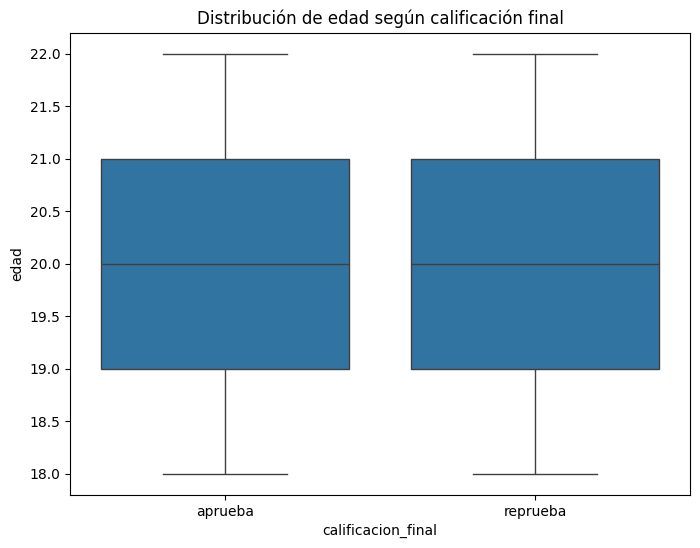

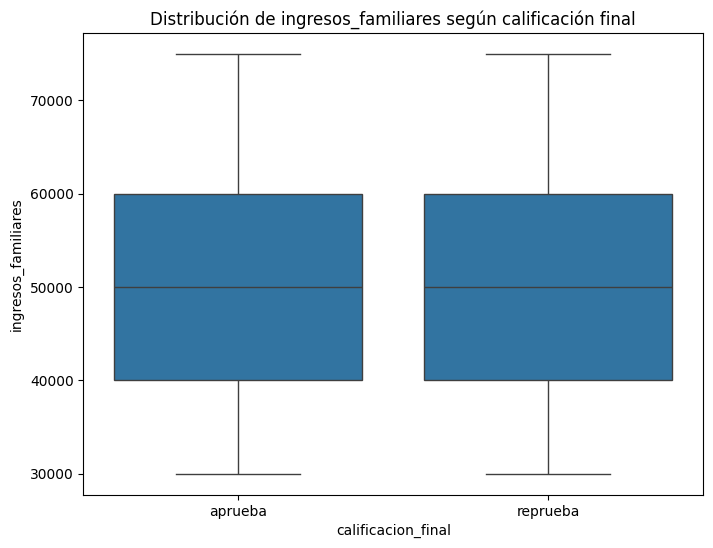

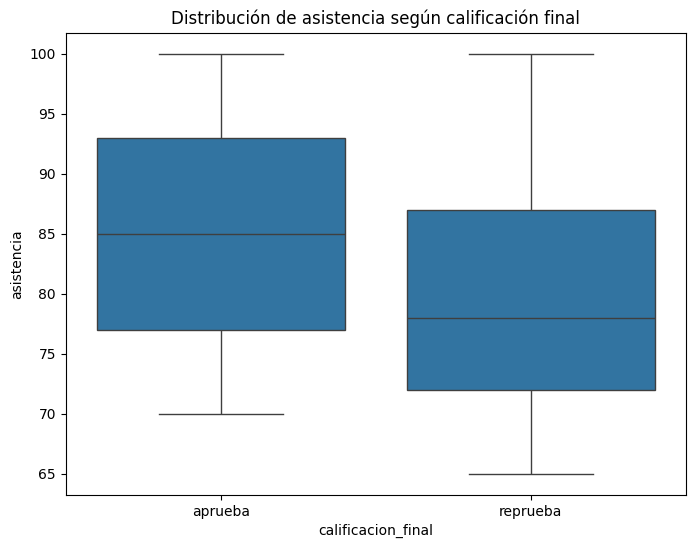

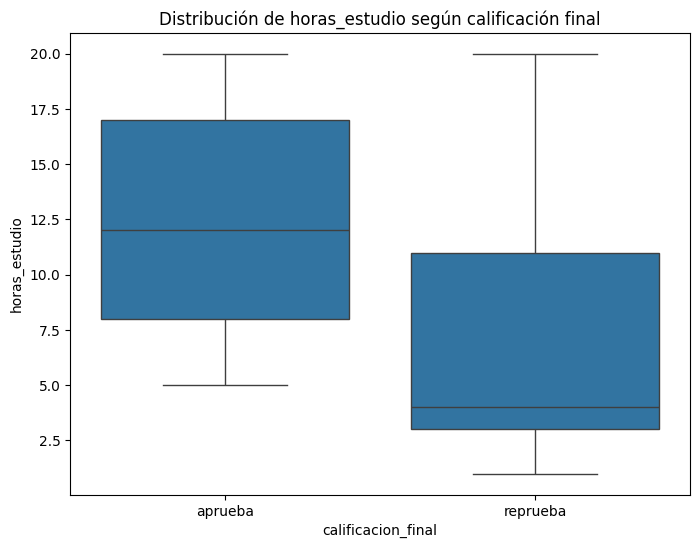

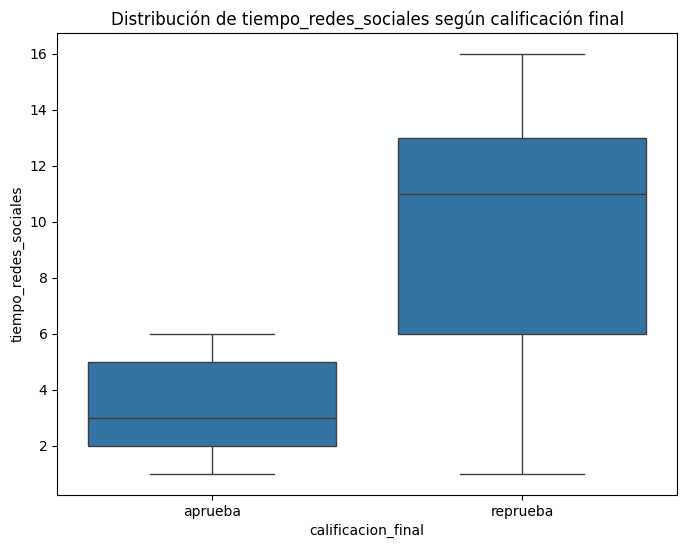

In [12]:
### Utilice diagramas u otro tipo de visualización de cajas para visualizar
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para cada variable predictora
predictors = ['edad', 'ingresos_familiares', 'asistencia', 'horas_estudio', 'tiempo_redes_sociales']
for predictor in predictors:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='calificacion_final', y=predictor, data=df)
    plt.title(f'Distribución de {predictor} según calificación final')
    plt.show()

**INSIGHTS**

La variable predictora con más diferencia entre sus medias, es el tiempo en redes sociales. La misma indica que, a mayor horas de dedicación en redes sociales, mayor es la tasa de reprobación.

# Parte 1: SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

Entrenaremos un modelo SVM a partir de los datos procesados.

In [14]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train[['asistencia', 'horas_estudio']], y_train)

SVC(probability=True, random_state=42)

In [15]:
# Evaluamos el moddelo en el conjunto de validación
y_pred = svm_model.predict(X_val[['asistencia',	'horas_estudio']])
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       375
           1       0.76      0.75      0.75       405

    accuracy                           0.75       780
   macro avg       0.75      0.75      0.75       780
weighted avg       0.75      0.75      0.75       780



Probemos escalando los datos usando `MinMaxScaler`.

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[['asistencia', 'horas_estudio']])
X_val_scaled = scaler.transform(X_val[['asistencia', 'horas_estudio']])
svm_model_scaled = SVC(kernel='rbf', probability=True, random_state=42)
svm_model_scaled.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

### **######### Todo #########**
Explique qué hace la celda anterior línea por línea.

* **from sklearn.preprocessing import MinMaxScaler**:
Importa la clase MinMaxScaler de scikit-learn, que se utiliza para escalar características numéricas a un rango específico (por defecto, entre 0 y 1).


* **scaler = MinMaxScaler():** Este objeto almacenará los parámetros necesarios para aplicar la misma transformación a los datos de entrenamiento y validación.


* **X_train_scaled = scaler.fit_transform(X_train[['asistencia', 'horas_estudio']]):**

  **fit_transform** realiza dos acciones de secuencia. **fit**: Calcula los valores mínimos y máximos de las columnas asistencia y horas_estudio en el conjunto de entrenamiento. Mientras que transform, Escala estas características al rango de la data, usando la fórmula del escalado. (Xescalado= (X-Xmin)/(Xmax - Xmin)).
  **X_train_scaled** contiene las versiones escaladas de las dos características seleccionadas.



* **X_val_scaled = scaler.transform(X_val[['asistencia', 'horas_estudio']]):**

  **transform()**: Aplica la misma transformación calculada con los datos de entrenamiento (usando los mismos mínimos y máximos) al conjunto de validación.
  No se usa fit_transform aquí para evitar data leakage. Los parámetros de escalado se derivan solo del conjunto de entrenamiento.


* **svm_model_scaled = SVC(kernel='rbf', probability=True, random_state=42):**
  
  **kernel**='rbf': Usa el kernel radial (RBF), común para problemas no lineales.

  **probability**=True: Permite estimar probabilidades (útil para métricas como la curva ROC).

  **random_state=42**: Gariza reproducibilidad en los resultados.
  

* **svm_model_scaled.fit(X_train_scaled, y_train):**
  Entrena el modelo SVM utilizando las características escaladas (X_train_scaled) y las etiquetas de entrenamiento (y_train). Al escalar los datos, se asegura que todas las características contribuyan equitativamente al cálculo de distancias en el kernel RBF, mejorando el rendimiento del modelo.

In [17]:
######### TODO #########
### Realizar la predicción en el conjunto de validación escalado utilizando el nuevo modelo entrenado.
y_pred_scaled = svm_model_scaled.predict(X_val_scaled)

print(classification_report(y_val, y_pred_scaled))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       375
           1       0.86      0.64      0.74       405

    accuracy                           0.76       780
   macro avg       0.78      0.77      0.76       780
weighted avg       0.78      0.76      0.76       780



### **######### Todo #########**
Interprete los resultados y compare los dos modelos previamente entrenados. ¿Qué modelo es mejor? ¿Por qué?

El modelo escalado tiene una precisión del 86%, lo que indica que predice con mayor exactitud quiénes reprueban. El macro promedio del F1-score es más alto en el modelo escalado (0.77) debido a un mejor rendimiento en ambas clases. El modelo no escalado podría tener un mejor recall para identificar más estudiantes que reprueban, aunque con más falsos positivos.
Por tanto, el modelo más adecuado en este caso sería SVM escalado, porque ofrece un mejor rendimiento general y una mayor precisión en la detección de estudiantes que reprueban, lo cual es crucial para tomar medidas preventivas a tiempo.

Ahora comparemos varios modelos con varios valores del hiperparámetro `C`.

In [18]:
svm_models = []
probabilities = []
predictions = []
for c in [0.1, 0.5, 1, 5, 10, 15]:
    model = SVC(kernel='rbf', probability=True, C=c, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    svm_models.append(model)
    # Probabilidades cercanas a 1 indica que es más probable que el estudiante repruebe (la clase "reprueba" es 1)
    probabilities.append(model.predict_proba(X_val_scaled))
    predictions.append(y_pred)
    print('Modelo con C=%s entrenado' % c)

Modelo con C=0.1 entrenado
Modelo con C=0.5 entrenado
Modelo con C=1 entrenado
Modelo con C=5 entrenado
Modelo con C=10 entrenado
Modelo con C=15 entrenado


Para comparar, grafiquemos nuestras curvas ROC para observar el rendimiento de nuestros modelos.

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, probabilities):
    plt.figure()
    for i, prob in enumerate(probabilities):
        fpr, tpr, _ = roc_curve(y_true, prob[:,1]) # Probabilidad de la clase positiva (reprueba) está en la segunda columna
        auc = roc_auc_score(y_true, prob[:,1]) # Probabilidad de la clase positiva (reprueba) está en la segunda columna
        plt.plot(fpr, tpr, label=f'C={svm_models[i].C}, AUC={auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

### **######### Todo #########**
Explique qué hacen la segunda y tercera línea dentro del lazo for de la celda anterior.

La segunda línea calcula la curva ROC, mientras que la 3era línea calcula el área bajo la curva ROC. Estas dos líneas sirven para evaluar el rendimiento de cada modelo SVM con diferentes valores del hiperparámetro C. Cada curva ROC representa el desempeño de un modelo con un valor específico de C, y el valor AUC correspondiente, permite comparar numéricamente su efectividad para identificar estudiantes en riesgo de reprobar.

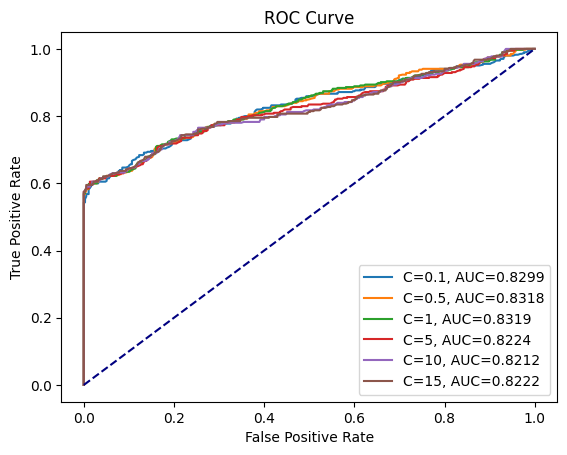

In [21]:
plot_roc_curve(y_val, probabilities)

### **######### Todo #########**
Responda de acuerdo a las curvas ROC:
* ¿Qué modelo tiene mejor rendimiento?
* ¿Existe alguna relación entre el hiperparámetro C y el rendimiento del modelo?

* El modelo con C=1 presenta el mejor rendimiento con un valor de AUC (Área Bajo la Curva) de 0.8319. Sin embargo, el modelo con C=0.5 también tiene un rendimiento alto, con un diferencia mínima con respecto al modelo C=1 (AUC=0.8318).
* De acuerdo con la gráfica, existe una relación no lineal entre el hiperparámetro C y AUC. Mientras C incrementa hasta 1, el rendimiento mejora progresivamente, mientras que si supera C=1, el rendimiento disminuye.

# Parte 2: Random Forest

Ahora entrenaremos un modelo de Random Forest.

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train[['asistencia', 'horas_estudio']], y_train)

RandomForestClassifier(random_state=42)

### **######### ToDo #########**
En la celda anterior hemos utilizado los hiperparámetros por defecto de la clase `RandomForestClassifier`. Responda cuáles son los valores por defecto de los siguientes hiperparámetros:
- `max_depth`
- `n_estimators`
- `min_samples_split`
- `criterion`


Puede revisar la documentación https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* **max_depth** = None
* **n_estimators** = 100
* **min_samples_split** = 2
* **criterion** = "gini"

In [23]:
y_pred_rf = rf_model.predict(X_val[['asistencia', 'horas_estudio']])
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       375
           1       0.76      0.72      0.74       405

    accuracy                           0.74       780
   macro avg       0.74      0.74      0.74       780
weighted avg       0.74      0.74      0.74       780



### **######### Todo #########**
Interprete los resultados y compare el modelo de Random Forest con el primer modelo SVM que entrenamos.

**SVM Escalado:**

Presenta un comportamiento asimétrico entre clases (alta sensibilidad para aprobados pero menor para reprobados)

Muy alta precisión (0.86) para la clase "reprueba", lo que significa muy pocos falsos positivos

El mejor valor de C=1 según las curvas ROC, con un AUC de 0.8319

**Random Forest:**

Comportamiento más equilibrado entre clases

Métricas más consistentes y homogéneas

Mejor capacidad para detectar estudiantes que reprueban (recall 0.72 vs 0.64)

### **######### ToDo #########**
En esta parte del laboratorio entrenaremos varios modelos basados en Random Forest. Similar a la parte 1 de este laboratorio, entrene varios modelos y visualice las curvas ROC para compararlos. En particular:
* Visualice las curvas ROC de 5 modelos con diferentes valores de `max_depth` (considere valores entre 3 y 12). Puede utilizar la función `plot_roc_curve` para visualizar las curvas ROC. Considere 1000 estimadores para todos los modelos a entrenar.
* ¿Qué modelo tiene mejor rendimiento?
* ¿Existe alguna relación entre el hiperparámetro `max_depth` y el rendimiento del modelo?
* ¿Existe alguna relación entre el hiperparámetro `max_depth` y la velocidad de entrenamiento del modelo (es decir el tiempo que a su computadora le tomó ejecutar el método `fit`)?

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import time

# Valores de max_depth
max_depth_values = [3, 6, 9, 12]

# Diccionario para almacenar resultados
results = {}

# Entrenar modelos con diferentes max_depth
for max_depth in max_depth_values:
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=1000, max_depth=max_depth, random_state=42)
    rf_model.fit(X_train[['asistencia', 'horas_estudio']], y_train)
    training_time = time.time() - start_time

    # Predicciones de probabilidad
    probabilities = rf_model.predict_proba(X_val[['asistencia', 'horas_estudio']])[:, 1]

    # Calcular curva ROC y AUC
    fpr, tpr, _ = roc_curve(y_val, probabilities)
    auc = roc_auc_score(y_val, probabilities)

    # Almacenar resultados
    results[max_depth] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc,
        'training_time': training_time
    }

results

{3: {'fpr': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00533333, 0.008     ,
         0.01333333, 0.016     , 0.02666667, 0.02933333, 0.03466667,
         0.03733333, 0.04      , 0.04266667, 0.04266667, 0.04266667,
         0.04533333, 0.048     , 0.05066667, 0.05333333, 0.056     ,
         0.06133333, 0.064     , 0.06933333, 0.07466667, 0.08266667,
         0.08533333, 0.08533333, 0.088     , 0.088     , 0.09866667,
         0.10133333, 0.10133333, 0.104     , 0.12      , 0.12533333,
         0.13333333, 0.136     , 0.14133333, 0.14933333, 0.14933333,
         0.14933333, 0.1

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import time

# Cargar datos
file_path = 'data_calificaciones.csv'
df = pd.read_csv(file_path)

# Preprocesamiento
X = df.drop(columns=['calificacion_final'])
y = df['calificacion_final'].map({'aprueba': 0, 'reprueba': 1})
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Valores de max_depth
max_depth_values = [3, 6, 9, 12]

# Diccionario para almacenar resultados
results = {}

# Entrenar modelos con diferentes max_depth
for max_depth in max_depth_values:
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=1000, max_depth=max_depth, random_state=42)
    rf_model.fit(X_train[['asistencia', 'horas_estudio']], y_train)
    training_time = time.time() - start_time

    # Predicciones de probabilidad
    probabilities = rf_model.predict_proba(X_val[['asistencia', 'horas_estudio']])[:, 1]

    # Calcular curva ROC y AUC
    fpr, tpr, _ = roc_curve(y_val, probabilities)
    auc = roc_auc_score(y_val, probabilities)

    # Almacenar resultados
    results[max_depth] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc,
        'training_time': training_time
    }

results

{3: {'fpr': array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00533333, 0.008     , 0.01333333, 0.016     , 0.02666667,
         0.02933333, 0.03466667, 0.03733333, 0.04      , 0.04266667,
         0.04266667, 0.04266667, 0.04533333, 0.048     , 0.05066667,
         0.05333333, 0.05866667, 0.064     , 0.072     , 0.07733333,
         0.08      , 0.08266667, 0.08266667, 0.08533333, 0.088     ,
         0.09866667, 0.09866667, 0.10933333, 0.11466667, 0.11466667,
         0.12266667, 0.128     , 0.13333333, 0.13333333, 0.136     ,
         0.136     , 0.13866667, 0.14666667, 0.152     , 0.15466667,
         0.16266667, 0.1

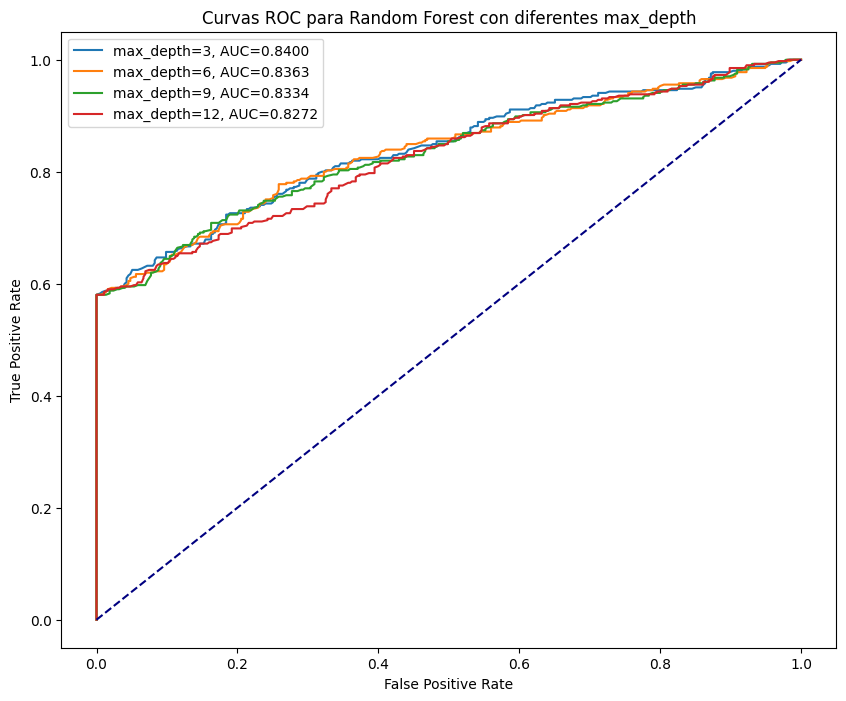

In [26]:
# Visualizar curvas ROC
plt.figure(figsize=(10, 8))
for max_depth, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'max_depth={max_depth}, AUC={result["auc"]:.4f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para Random Forest con diferentes max_depth')
plt.legend()
plt.show()

# **RESPUESTAS**

* **¿Qué modelo tiene mejor rendimiento?**

  El modelo con max_depth=3 obtiene el mejor rendimiento con un AUC de 0.8400. En otras palabras, la configuración más simple entre las evaluadas logra la mejor capacidad predictiva en este conjunto de datos.
* **¿Existe alguna relación entre el hiperparámetro `max_depth` y el rendimiento del modelo?**

  A medida que aumenta el valor de max_depth, el AUC disminuye gradualmente. Aunque, la diferencia entre el mejor y el peor modelo es relativamente pequeña (0.0128), pero consistente.

* **¿Existe alguna relación entre el hiperparámetro `max_depth` y la velocidad de entrenamiento del modelo (es decir el tiempo que a su computadora le tomó ejecutar el método `fit`)?**

  En los códigos previos se puede observar la variable 'training_time', y este aumenta a medida que el rango evaluado incrementa. Por tanto, los modelos con menor profundidad no solo tienen mejor rendimiento predictivo sino que también son más eficientes en términos de tiempo de entrenamiento.

# Parte 3: XGBoost

In [27]:
# Ya que scikit-learn no integra XGBoost, es necesario instalarlo:
!pip install xgboost

In [28]:
# Ahora la es posible importar la clase del clasificador XGBoost
from xgboost import XGBClassifier

In [29]:
######### TODO #########
### Instancie un objeto de la clase XGBClassifier usando un valor de random_state
# y los demás hiperparámetros por defecto.

xgb_model = XGBClassifier(random_state=42)

In [30]:
xgb_model.fit(X_train[['asistencia', 'horas_estudio']], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [31]:
y_pred_xgb = xgb_model.predict(X_val[['asistencia', 'horas_estudio']])
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       375
           1       0.78      0.70      0.74       405

    accuracy                           0.74       780
   macro avg       0.74      0.74      0.74       780
weighted avg       0.75      0.74      0.74       780



### **######### ToDo OPCIONAL #########**
Interprete los resultados y compare el modelo de XGBoost con los primeros modelos que entrenamos de SVM y Random Forest.

Cuando identifica estudiantes en riesgo, hay una alta confiabilidad en el modelo SVM (86% de precisión). Si se busca detectar la mayor cantidad de estudiantes en riesgo, Random Forest identifica correctamente el 72% de los estudiantes que reprueban, siendo el mejor en este aspecto. Mientras que, si se busca un modelo equilibrado, XGBoost es el adecuado, pues ofrece un buen compromiso entre precisión (78%) y recall (70%) para la clase "reprueba", con un comportamiento balanceado entre ambas clases.

### **######### ToDo OPCIONAL #########**
Es importante en ocasiones hacer análisis detallados de los errores de los modelos que creamos. Utilice la función `confusion_matrix` ((https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) para responder las siguientes preguntas sobre las predicciones de nuestro modelo de XGBoost previamente entrenado:

- ¿Cuántos falsos positivos muestra nuestro modelo?
- ¿Cuántos falsos negativos muestra nuestro modelo?



### **######### Todo OPCIONAL #########**
En esta parte del laboratorio entrenaremos varios modelos basados en XGBoost. Similar a la parte 1 y 2 de este laboratorio, entrene varios modelos y visualice las curvas ROC para compararlos. En particular:
* Visualice las curvas ROC de 5 modelos con diferentes valores de `max_depth` (considere valores entre 3 y 12). Puede utilizar la función `plot_roc_curve` para visualizar las curvas ROC. Considere 1000 estimadores para todos los modelos a entrenar.
* ¿Qué modelo tiene mejor rendimiento?
* ¿Existe alguna relación entre el hiperparámetro `max_depth` y el rendimiento del modelo?
* ¿Existe alguna relación entre el hiperparámetro `max_depth` y la velocidad de entrenamiento del modelo (es decir el tiempo que a su computadora le tomó ejecutar el método `fit`)?
* Con base a las tres partes del laboratorio, ¿qué modelo elegiría para predecir si un estudiante reprobará un curso?